In [21]:
import pandas as pd
from orbit.models import ETS
from orbit.models import DLT
from orbit.diagnostics.backtest import BackTester
from orbit.models import KTR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from concurrent.futures import ThreadPoolExecutor
import concurrent
import json
from typing import Any, Callable, Dict, Tuple
import itertools
from metrics import print_evaluation_metrics

In [22]:
file_path = "../data/WHO-COVID-19-global-data.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path)
df = df[[date_column, target_column, "New_cases"]]
df = df.groupby(date_column).sum().reset_index()
df = df.dropna()
df[date_column] = pd.to_datetime(df.pop(date_column), format="%Y-%m-%d")
# df.set_index(date_time, inplace=True, drop=False)

train = df.iloc[:-30]
valid = df.iloc[-30:]

In [23]:
def evaluate_grid(
    model_function: Callable[[Dict[str, Any], str, str], Any],
    grid: Dict[str, Any],
    train: pd.DataFrame,
    date_column: str,
    target_column: str,
) -> Tuple[Dict[str, Any], float]:
    """
    Evaluate a forecasting model on a given parameter grid.

    This function uses a model creation function to initialize a model with the provided
    grid of parameters, performs backtesting using the provided training data, and computes
    the root mean squared error (RMSE) of the predictions.

    Parameters:
    - model_function (Callable[[Dict[str, Any], str, str], Any]): A function that creates
      a model instance. It should accept a parameter grid, a date column name, and a target
      column name.
    - grid (Dict[str, Any]): A dictionary containing the parameters for the model.
    - train (pd.DataFrame): The training dataset as a Pandas DataFrame.
    - date_column (str): The name of the column in 'train' that contains the date information.
    - target_column (str): The name of the target column in 'train'.

    Returns:
    - Tuple[Dict[str, Any], float]: A tuple containing the grid of parameters and the
      corresponding RMSE score.
    """
    model = model_function(grid, date_column, target_column)

    bt = BackTester(
        df=train, model=model, forecast_len=90, n_splits=5, window_type="rolling"
    )

    bt.fit_predict()
    predicted_df = bt.get_predicted_df()

    score = sqrt(mean_squared_error(predicted_df["actual"], predicted_df["prediction"]))
    return grid, score

In [ ]:
param_grid = {
    "seasonality": [None, 90, 180, 360],
    "level_sm_input": [None, 0, 0.3, 0.5, 0.8, 1],
    "seasonality_sm_input": [None, 0, 0.3, 0.5, 0.8, 1],
}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

In [7]:
ets_scores = dict()


def ets_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an ETS model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the ETS model configured with the given parameters.
    """
    return ETS(
        date_col=date_column,
        response_col=target_column,
        prediction_percentiles=[5, 95],
        seed=1,
        **grid
    )


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(
            evaluate_grid, ets_function, option, train, date_column, target_column
        ): option
        for option in combinations_as_dicts
    }
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        ets_scores[json.dumps(option)] = score

2023-11-26 09:59:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 09:59:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 09:59:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 09:59:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








































































































chain 1 |██▌       | 00:00 Status













































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)








































































chain 4 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 1 |██████████| 00:01 Sampling completed                     








chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 09:59:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status2023-11-26 09:59:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 09:59:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

2023-11-26 09:59:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |██▌       | 00:00 Status

























































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

























































































chain 1 |███████▌  | 00:00 Iteration

chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)











































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:02 Sampling completed                     
chain 1 |██████████| 00:02 Sampling completed                     


chain 2 |██████████| 00:02 Sampling completed                     


chain 3 |██████████| 00:02 Sampling completed                     


chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


chain 4 |██████████| 00:02 Sampling completed                     


2023-11-26 09:59:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 09:59:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 09:59:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













2023-11-26 09:59:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
















































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

































































chain 2 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)


































































































chain 1 |██████████| 00:01 Sampling completed                     













chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:02 Sampling completed                     

2023-11-26 09:59:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 09:59:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 2 |          | 00:00 Status2023-11-26 09:59:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.2023-11-26 09:59:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


























































chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 4 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)















































































































































chain 1 |██████████| 00:02 Sampling completed                     


























chain 2 |██████████| 00:02 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 09:59:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 09:59:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 09:59:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







2023-11-26 09:59:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)































































































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)















































































chain 2 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


















































chain 2 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)



































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:00:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:00:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







2023-11-26 10:00:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












2023-11-26 10:00:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)












































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






























































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
















































































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                   

chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


2023-11-26 10:00:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:00:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██▌       | 00:00 Status

















2023-11-26 10:00:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:00:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)














































































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)





















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

















chain 4 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)





















































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:02 Sampling completed                     

chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2023-11-26 10:00:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:00:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





















2023-11-26 10:00:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














2023-11-26 10:00:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
























































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
























chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)











































































































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                   


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:00:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:00:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██▌       | 00:00 Status

















2023-11-26 10:00:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


2023-11-26 10:00:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)























































































chain 1 |███████▌  | 00:01 Iteratio




















































chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)




























chain 1 |██████████| 00:01 Sampling completed                     











chain 2 |██████████| 00:01 Sampling completed                     






















































chain 3 |██████████| 00:01 Sampling completed                     











chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     

chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:00:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status2023-11-26 10:00:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

2023-11-26 10:00:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














chain 1 |██▌       | 00:00 Status







































2023-11-26 10:00:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)














































































































chain 1 |██████████| 00:01 Sampling completed                     























chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     





































chain 2 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:02 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:00:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
2023-11-26 10:00:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |██▌       | 00:00 Status

















2023-11-26 10:00:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)







































2023-11-26 10:00:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
















































































































































































































































chain 1 |██████████| 00:01 Sampling completed                     











chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                   












chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed
















chain 3 |██████████| 00:01 Sampling completed                   

chain 3 |██████████| 00:01 Sampling completed














chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed

2023-11-26 10:00:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:00:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:00:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:00:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

























































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






























































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:00:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:00:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:00:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2023-11-26 10:00:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)








































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)























































































































































chain 1 |██████████| 00:01 Sampling completed                     






























chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:00:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:00:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:00:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:00:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






































































































chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






































































































































































































chain 1 |██████████| 00:02 Sampling completed
chain 1 |██████████| 00:01 Sampling completed










chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed
chain 3 |██████████| 00:01 Sampling completed                   
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     

chain 4 |██████████| 00:01 Sampling completed                   


chain 3 |██████████| 00:01 Sampling completed                   


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:00:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:00:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:00:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























chain 4 |          | 00:00 Status2023-11-26 10:00:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)







































































































chain 1 |███████▌  | 00:00 Iteration: 100 /








chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 2 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)













































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)

























chain 2 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)


























































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 1 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


chain 2 |██████████| 00:02 Sampling completed                     


chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2023-11-26 10:00:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:00:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





















2023-11-26 10:00:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:00:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


























































































































chain 1 |          | 00:00 Iterat







chain 1 |██████████| 00:01 Sampling completed                     






















































































chain 2 |██████████| 00:01 Sampling completed                   






























































































































chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                   


chain 1 |██████████| 00:01 Sampling completed                   
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                   















chain 3 |██████████| 00:01 Sampling completed                   

chain 3 |██████████| 00:01 Sampling completed














chain 4 |██████████| 00:01 Sampling completed

2023-11-26 10:00:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:00:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







2023-11-26 10:00:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



2023-11-26 10:00:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


































































































































































chain 1 |   

chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




































































































































chain 1 |██████████| 00:01 Sampling completed                     


















































chain 2 |██████████| 00:01 Sampling completed                     










chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:00:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:00:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















2023-11-26 10:00:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 4 |██▌       | 00:00 Status2023-11-26 10:00:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
























































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
















































chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)







































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     







































chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:00:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 4 |          | 00:00 Status2023-11-26 10:00:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██▌       | 00:00 Status

















2023-11-26 10:00:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:00:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)



























chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)



























































chain 2 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)
































































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     









chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed











chain 2 |██████████| 00:01 Sampling completed
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                   


chain 3 |██████████| 00:01 Sampling completed                     

chain 4 |██████████| 00:01 Sampling completed                   

chain 4 |██████████| 00:01 Sampling completed

2023-11-26 10:00:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:00:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:00:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:00:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
















































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


















































































chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 2 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)




















chain 4 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:01:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:01:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██▌       | 00:00 Status






2023-11-26 10:01:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






























2023-11-26 10:01:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)














































































































chain

chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




















































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     














chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     










chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)











































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     











chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed
chain 2 |██████████| 00:01 Sampling completed                   


chain 3 |██████████| 00:01 Sampling completed                   

















chain 4 |██████████| 00:01 Sampling completed                   


2023-11-26 10:01:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:01:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















2023-11-26 10:01:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:01:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
























































































c










chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     






































chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 4 |██████████| 00:01 Sampling completed                     

chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)










































chain 2 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)


























































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:01:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:01:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






2023-11-26 10:01:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2023-11-26 10:01:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




















































































































































chain 1 | 

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




























































































































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                   


chain 3 |██████████| 00:01 Sampling completed                   


chain 4 |██████████| 00:01 Sampling completed                   

2023-11-26 10:01:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:01:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:01:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)res: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






































































































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)






































































chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






























































































































chain 1 |██████████| 00:01 Sampling completed                     

























chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:01:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



2023-11-26 10:01:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:01:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:01:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
































































































































chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)








































































































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:01:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:01:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:01:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


2023-11-26 10:01:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
























































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)














































chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     







chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                   

2023-11-26 10:01:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:01:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







2023-11-26 10:01:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







2023-11-26 10:01:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)







































































































































chain

chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)























































































































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                   


chain 3 |██████████| 00:01 Sampling completed                   

chain 3 |██████████| 00:01 Sampling completed                     














chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed

2023-11-26 10:01:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:01:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:01:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:01:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)












































chain 1 |██████████| 00:00 Iteration: 200 / 250

























































































































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     














chain 1 |██████████| 00:01 Sampling completed                   
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed


chain 2 |██████████| 00:01 Sampling completed                   


chain 3 |██████████| 00:01 Sampling completed                   
chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:01:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:01:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:01:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:01:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)























































































chain 1 |          | 00:

chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     

chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:01:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status2023-11-26 10:01:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:01:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |██▌       | 00:00 Status


























chain 1 |██▌       | 00:00 Status2023-11-26 10:01:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)












































































































































chain 1 |███









































chain 2 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)









































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                   
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:01:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:01:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:01:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


















2023-11-26 10:01:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




































































































































































chain 1 |          


















































































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:01:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:01:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:01:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:01:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




















































































































































































































































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:01:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:01:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)res: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.2023-11-26 10:01:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed    

chain 1 |██▌       | 00:00 Status





































































chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


























































































































































































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                   

2023-11-26 10:01:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:01:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:01:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:01:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)











































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)



































































































chain 1 | 

chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)










































































chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)









































































chain 1 |██████████| 00:01 Sampling completed                     










































chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:01:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:01:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


2023-11-26 10:01:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:01:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)









































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)
















































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






























































































































chain 1 |██████████| 00:01 Sampling completed                     









chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:01:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:01:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2023-11-26 10:01:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:01:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)







































































































































chain 1 |       

chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)













































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)














































































































chain 1 |██████████| 00:01 Sampling completed                     









chain 2 |██████████| 00:01 Sampling completed                     













chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
























chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:01:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:01:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:01:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)res: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)















































chain 1 |        

chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:02:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:02:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:02:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









2023-11-26 10:02:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
























































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)



























































































































chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)





















































































































































































chain 1 |██████████| 00:01 Sampling completed                   
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                   
chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                   
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                   


chain 4 |██████████| 00:01 Sampling completed                     

chain 4 |██████████| 00:01 Sampling completed                   

chain 4 |██████████| 00:01 Sampling completed

2023-11-26 10:02:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:02:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:02:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:02:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)













































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)












































chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 3 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)

























































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                   


chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                   


chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:02:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:02:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:02:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






2023-11-26 10:02:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
























chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)























chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)










































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     












chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)























































chain 3 |██████████| 00:01 Sampling completed                     






chain 4 |██████████| 00:01 Sampling completed

chain 4 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)



























chain 1 |██████████| 00:01 Sampling completed                     













chain 2 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 2 |██████████| 00:01 Sampling completed                     














chain 3 |██████████| 00:01 Sampling completed                     
























chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:02:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:02:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:02:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |██▌       | 00:00 Status




































2023-11-26 10:02:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)









































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)



































chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

































































chain 2 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)





















































chain 1 |██████████| 00:01 Sampling completed                     



























































chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                   
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                   


chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:02:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:02:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:02:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)res: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)













































































































































chain 1 |          | 00:00 Iteration: 226 / 25














chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






















































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                   
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     













chain 3 |██████████| 00:01 Sampling completed                   

chain 1 |██████████| 00:01 Sampling completed











chain 3 |██████████| 00:01 Sampling completed
chain 2 |██████████| 00:01 Sampling completed
chain 4 |██████████| 00:01 Sampling completed                   

chain 3 |██████████| 00:01 Sampling completed                   

chain 3 |██████████| 00:01 Sampling completed
















chain 4 |██████████| 00:01 Sampling completed

2023-11-26 10:02:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:02:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




2023-11-26 10:02:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)








chain 1 |          | 00:00 Status2023-11-26 10:02:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

























































































































chain 2 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)



































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                   











chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed












chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed























chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed


chain 3 |██████████| 00:01 Sampling completed


chain 4 |██████████| 00:01 Sampling completed                   

2023-11-26 10:02:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:02:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:02:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2023-11-26 10:02:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)





















chain 1 |█





























































































































chain 1 |██████████| 00:01 Sampling completed
chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2023-11-26 10:02:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:02:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:02:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







2023-11-26 10:02:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
























































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


















































































































































chain 1 |

chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




















































































































































































































chain 1 |██████████| 00:01 Sampling completed                   
chain 1 |██████████| 00:01 Sampling completed                   
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                   














chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed

2023-11-26 10:02:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:02:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







2023-11-26 10:02:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






2023-11-26 10:02:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































































































































































































































































































2023-11-26 10:02:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |█████     | 00:19 Iteration:   1 / 250 [  0%]  (Warmup)






















































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     






















2023-11-26 10:02:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































chain 1 |███████▌  | 00:21 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:21 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     


chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     

2023-11-26 10:02:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:02:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     















































2023-11-26 10:03:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     







chain 1 |█████     | 00:15 Iteration:   1 / 250 [  0%]  (Warmup)






2023-11-26 10:03:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































chain 1 |███████▌  | 00:17 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |██████████| 00:18 Iteration: 200 / 250 [ 80%]  (Warmup)























chain 1 |          | 00:19 Iteration: 226 / 250 [ 90%]  (Sampling)











chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     












2023-11-26 10:03:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     

2023-11-26 10:03:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2023-11-26 10:03:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































































































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     

2023-11-26 10:03:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































chain 1 |█████     | 00:19 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |███████▌  | 00:22 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |██████████| 00:22 Iteration: 200 / 250 [ 80%]  (Warmup)

































chain 1 |          | 00:23 Iteration: 226 / 250 [ 90%]  (Sampling)
































chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     

chain 2 |██████████| 00:14 Iteration: 200 / 250 [ 80%]  (Warmup)







































chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     
































2023-11-26 10:03:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

























chain 1 |██▌       | 00:00 Status













2023-11-26 10:03:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2023-11-26 10:03:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































































































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

2023-11-26 10:03:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 00:15 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:16 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 00:17 Iteration: 226 / 250 [ 90%]  (Sampling)






































































































































































































































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     

chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     


chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     

2023-11-26 10:04:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:04:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:04:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































































































































































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling

2023-11-26 10:04:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

chain 1 |█████     | 00:16 Iteration:   1 / 250 [  0%]  (Warmup)





























2023-11-26 10:04:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |███████▌  | 00:18 Iteration: 100 / 250 [ 40%]  (Warmup)

















chain 1 |██████████| 00:19 Iteration: 200 / 250 [ 80%]  (Warmup)






















chain 1 |          | 00:19 Iteration: 226 / 250 [ 90%]  (Sampling)














































































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     














chain 4 |██████████| 00:13 Sampling com

chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     















chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     










2023-11-26 10:04:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:04:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































2023-11-26 10:04:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chai






































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 4 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)

2023-11-26 10:04:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:04:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)





































































chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)

























chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling comp

chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

















































































































2023-11-26 10:04:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



























2023-11-26 10:04:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


2023-11-26 10:04:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)






























































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     










chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)











2023-11-26 10:04:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     
























2023-11-26 10:04:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     











































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     












2023-11-26 10:04:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























chain 1 |          | 00:00 Status



























chain 1 |██▌       | 00:00 Status















































































2023-11-26 10:04:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2023-11-26 10:05:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)



















































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     






chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 3 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)































chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)



























chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)2023-11-26 10:05:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

chain 1 |          | 00:00 Status















chain 1 |██▌       | 00:00 Status


chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     


















































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)

2023-11-26 10:05:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     2023-11-26 10:05:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 4 |██████████| 00:12 Sampling completed                     



































































2023-11-26 10:05:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2023-11-26 10:05:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status



















chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)









chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)

























chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)

















































chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)






















































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     






















































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     






























chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     










































































































2023-11-26 10:05:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:00 Status















2023-11-26 10:05:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     






























































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)


2023-11-26 10:05:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































2023-11-26 10:05:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)

































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     











































































































































2023-11-26 10:05:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |          | 00:00 Status

























































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     







































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     







chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)





















2023-11-26 10:05:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































2023-11-26 10:05:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)
















chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)






































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                    

chain 3 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)
















chain 4 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)














chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     













































































































































































2023-11-26 10:05:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |          | 00:00 Status















2023-11-26 10:05:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)

2023-11-26 10:05:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































2023-11-26 10:05:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)

















chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)



























chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)






















chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling 

















































2023-11-26 10:05:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |          | 00:00 Status


























































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)







































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     







chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2023-11-26 10:05:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status2023-11-26 10:05:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

2023-11-26 10:05:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































2023-11-26 10:05:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     


chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


chain 4 |██████████| 00:07 Sampling completed                     

2023-11-26 10:06:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-11-26 10:06:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:06:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































































chain 1 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)







































































chain 1 |███████▌  | 00:16 Iteration: 100 / 250 [ 40%]  (Warmup)




































chain 1 |██████████| 00:17 Iteration: 200 / 250 [ 80%]  (Warmup)




















chain 1 |█████████

chain 1 |          | 00:17 Iteration: 226 / 250 [ 90%]  (Sampling)






















































2023-11-26 10:06:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     
























chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     










































































































































































chain 1 |██████████| 00:11 Sampling completed                     s: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


2023-11-26 10:06:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status











chain 1 |██▌       | 00:00 Status







































































2023-11-26 10:06:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2023-11-26 10:06:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































chain 1 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)














































































chain 1 |███████▌  | 00:17 Iteration: 100 / 250 [ 40%]  (Warmup)




























chain 1 |██████████| 00:17 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 1 |          | 00:18 Iteration: 226 / 250 [ 90%]  (Sampling)

















































































































































































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                  


chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     





































































chain 1 |██████████| 00:19 Sampling completed                     
chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     


chain 4 |██████████| 00:16 Sampling completed                     

2023-11-26 10:06:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:06:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██▌       | 00:00 Status


















2023-11-26 10:06:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:06:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































































































































































































































chain 1 |█████     | 00:17 Iteration:   1 / 250 [  0%]  (Warmup)



































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2023-11-26 10:06:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |██████████| 00:18 Sampling completed                     







chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

chain 2 |          | 00:00 Status

















chain 1 |███████▌  | 00:19 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:19 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:20 Iteration: 226 / 250 [ 90%]  (Sampling)2023-11-26 10:06:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |██████████| 00:20 Sampling completed                     s: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     

chain 1 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status
2023-11-26 10:07:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     






























chain 1 |█████     | 00:15 Iteration:   1 / 250 [  0%]  (Warmup)







2023-11-26 10:07:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































chain 1 |███████▌  | 00:18 Iteration: 100 / 250 [ 40%]  (Warmup)































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     


chain 1 |██████████| 00:18 Iteration: 200 / 250 [ 80%]  (Warmup)




























chain 1 |          | 00:19 Iteration: 226 / 250 [ 90%]  (Sampling)























































2023-11-26 10:07:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     



chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     

2023-11-26 10:07:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
2023-11-26 10:07:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

















2023-11-26 10:07:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

2023-11-26 10:07:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |█████     | 00:15 Iteration:   1 / 250 [  0%]  (Warmup)

























































































chain 1 |███████▌  | 00:18 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:18 Iteration: 200 / 250 [ 80%]  (Warmup)























chain 1 |          | 00:19 Iteration: 226 / 250 [ 90%]  (Sampling)



























































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     


chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     




















2023-11-26 10:07:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status2023-11-26 10:07:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     










2023-11-26 10:07:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































































































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     






























































































2023-11-26 10:07:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     











































2023-11-26 10:08:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     







































2023-11-26 10:08:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































chain 1 |█████     | 00:16 Iteration:   1 / 250 [  0%]  (Warmup)































chain 1 |███████▌  | 00:18 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |          | 00:19 Iteration: 226 / 250 [ 90%]  (Sampling)



























chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     















2023-11-26 10:08:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














chain 1 |██▌       | 00:00 Status






























































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     















































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     








2023-11-26 10:08:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































2023-11-26 10:08:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

2023-11-26 10:08:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

chain 1 |█████     | 00:15 Iteration:   1 / 250 [  0%]  (Warmup)

































2023-11-26 10:08:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |███████▌  | 00:17 Iteration: 100 / 250 [ 40%]  (Warmup)























chain 1 |██████████| 00:17 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     





































2023-11-26 10:08:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

























2023-11-26 10:08:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     


























2023-11-26 10:08:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-11-26 10:08:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































chain 1 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)
































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     




chain 1 |███████▌  | 00:15 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:16 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 00:16 Iteration: 226 / 250 [ 90%]  (Sampling)2023-11-26 10:08:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     
















2023-11-26 10:08:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status

























































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     


































2023-11-26 10:08:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     

2023-11-26 10:08:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

















2023-11-26 10:09:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |█████     | 00:16 Iteration:   1 / 250 [  0%]  (Warmup)






























































































































chain 1 |███████▌  | 00:18 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:18 Iteration: 200 / 250 [ 80%]  (Warmup)



















chain 1 |          | 00:19 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     













chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     












chain 3 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)



















2023-11-26 10:09:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








chain 1 |██▌       | 00:00 Status








2023-11-26 10:09:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

chain 3 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)




















































2023-11-26 10:09:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-11-26 10:09:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)





































chain 1 |███████▌  | 00:14 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:15 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 00:16 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     














chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     












chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

2023-11-26 10:09:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
























chain 1 |██▌       | 00:00 Status





































2023-11-26 10:09:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     





















2023-11-26 10:09:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     

2023-11-26 10:09:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)















































chain 1 |███████▌  | 00:15 Iteration: 100 / 250 [ 40%]  (Warmup)








































chain 1 |██████████| 00:15 Iteration: 200 / 250 [ 80%]  (Warmup)
























chain 1 |          | 00:16 Iteration: 226 / 250 [ 90%]  (Sampling)










































































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     
















chain 3 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)















































chain 2 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)








































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

chain 2 |██████████| 00:18 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     







chain 2 |          | 00:18 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

2023-11-26 10:09:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:09:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-11-26 10:09:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:09:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     






































2023-11-26 10:09:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































2023-11-26 10:10:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)

























































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     















chain 1 |███████▌  | 00:14 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:14 Iteration: 200 / 250 [ 80%]  (Warmup)

























2023-11-26 10:10:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

chain 2 |██▌       | 00:00 Status













































































2023-11-26 10:10:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















chain 1 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status












































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


































2023-11-26 10:10:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-11-26 10:10:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     












chain 3 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)



































































2023-11-26 10:10:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     


chain 1 |█████     | 00:15 Iteration:   1 / 250 [  0%]  (Warmup)





























chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


chain 1 |███████▌  | 00:16 Iteration: 100 / 250 [ 40%]  (Warmup)
























chain 1 |██████████| 00:16 Iteration: 200 / 250 [ 80%]  (Warmup)












2023-11-26 10:10:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:17 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:17 Sampling completed                     












chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2023-11-26 10:10:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



























chain 1 |██▌       | 00:00 Status

































































2023-11-26 10:10:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2023-11-26 10:10:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)

























































chain 1 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)































chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)



































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     












chain 3 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)




























chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

chain 4 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)





















































































































2023-11-26 10:10:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





































chain 1 |██████████| 00:15 Sampling completed                     s: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     


















chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-11-26 10:10:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:10:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)

























































chain 1 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)






























































































chain 1 |          | 00:14 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:14 Sampling completed            






























chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)


































































chain 1 |██████████| 00:13 Sampling completed                     












chain 2 |██████████| 00:13 Sampling completed                     













chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)
































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2023-11-26 10:10:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status2023-11-26 10:10:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-11-26 10:10:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































2023-11-26 10:10:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)





























chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)













































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     








2023-11-26 10:11:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








































































chain 1 |██▌       | 00:00 Status
2023-11-26 10:11:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     




























chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

2023-11-26 10:11:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























2023-11-26 10:11:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)




















chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)

























































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling co




















































































2023-11-26 10:11:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

chain 4 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)



















































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     



























chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     


chain 4 |██████████| 00:14 Sampling completed                     

2023-11-26 10:11:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-11-26 10:11:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:11:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)






chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████|

2023-11-26 10:11:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status






























































































































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     



























































































2023-11-26 10:11:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     













chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)










chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

2023-11-26 10:11:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































2023-11-26 10:11:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2023-11-26 10:11:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status































































































































































































































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     











2023-11-26 10:12:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     



chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     










chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     


chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)




2023-11-26 10:12:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















2023-11-26 10:12:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)


































































































chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)









































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     










































2023-11-26 10:12:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |          | 00:00 Status















chain 1 |██▌       | 00:00 Status





























































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     
























2023-11-26 10:12:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)






























2023-11-26 10:12:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     













chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)








2023-11-26 10:12:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     























































2023-11-26 10:12:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


























chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     























2023-11-26 10:12:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     






















































2023-11-26 10:12:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     




chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)














2023-11-26 10:12:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-11-26 10:12:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
























chain 1 |██▌       | 00:00 Status2023-11-26 10:12:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     























2023-11-26 10:12:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)

































































2023-11-26 10:12:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)


2023-11-26 10:12:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)



































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-11-26 10:12:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status

















































































































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     2023-11-26 10:12:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 4 |██████████| 00:10 Sampling completed                     








































































chain 4 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:13:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)






























































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     


chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 2 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)2023-11-26 10:13:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:13 Sampling completed                     












chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

chain 1 |██▌       | 00:00 Status

2023-11-26 10:13:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status









































































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)

























chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)res: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)
























2023-11-26 10:13:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

chain 2 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-11-26 10:13:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:13:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     






























































2023-11-26 10:13:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     












chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)






























2023-11-26 10:13:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)
2023-11-26 10:13:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2023-11-26 10:13:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status















































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     





















































2023-11-26 10:13:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)












2023-11-26 10:13:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

chain 4 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)

































































2023-11-26 10:13:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













chain 1 |██▌       | 00:00 Status











chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     
















2023-11-26 10:13:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     























2023-11-26 10:13:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     


chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)















































































2023-11-26 10:14:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     


chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)2023-11-26 10:14:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     





2023-11-26 10:14:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status

















































































































































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     



























2023-11-26 10:14:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















2023-11-26 10:14:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

2023-11-26 10:14:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































chain 1 |█████     | 00:18 Iteration:   1 / 250 [  0%]  (Warmup)











































chain 1 |██████████| 00:21 Iteration: 200 / 250 [ 80%]  (Warmup)



































































chain 1 |          | 00:22 Iteration: 226 / 250 [ 90%]  (Sampling)













































chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     










chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     







2023-11-26 10:14:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status

2023-11-26 10:14:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































































chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     






































2023-11-26 10:14:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     

2023-11-26 10:14:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































chain 1 |█████     | 00:17 Iteration:   1 / 250 [  0%]  (Warmup)


























































































chain 1 |███████▌  | 00:20 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     

chain 1 |██████████| 00:21 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:21 Iteration: 226 / 250 [ 90%]  (Sampling)2023-11-26 10:14:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     

2023-11-26 10:14:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











































































































































































































































chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     












chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     


































2023-11-26 10:15:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:15:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































































































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

chain 1 |█████     | 00:17 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:15:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































chain 1 |███████▌  | 00:20 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |          | 00:22 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     

2023-11-26 10:15:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status







































































































































































































































chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     















































































2023-11-26 10:15:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     





























2023-11-26 10:15:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     

2023-11-26 10:15:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































chain 1 |█████     | 00:16 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |███████▌  | 00:20 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:20 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     

2023-11-26 10:15:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











































































































































































































































































































chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     

























































































chain 1 |          | 00:22 Iteration: 226 / 250 [ 90%]  (Sampling)2023-11-26 10:15:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     







chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     


chain 4 |██████████| 00:22 Sampling completed                     

2023-11-26 10:15:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























2023-11-26 10:15:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































chain 1 |█████     | 00:20 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:23 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:23 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:24 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     

2023-11-26 10:16:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status



















































































































































































































































chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     


chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)






































































































chain 1 |██████████| 00:23 Sampling completed                     s: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     



















































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)













2023-11-26 10:16:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)





























chain 1 |██████████| 00:26 Sampling completed                     
chain 2 |██████████| 00:26 Sampling completed                     
chain 3 |██████████| 00:26 Sampling completed                     
chain 4 |██████████| 00:26 Sampling completed                     








2023-11-26 10:16:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     













































































2023-11-26 10:16:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
























































































































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     






2023-11-26 10:16:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































2023-11-26 10:16:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     




















chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)



















2023-11-26 10:16:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)

























2023-11-26 10:16:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     
















chain 3 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)










































































2023-11-26 10:16:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status








































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     






























































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     




















2023-11-26 10:16:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


2023-11-26 10:16:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































2023-11-26 10:16:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)

























































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     




chain 3 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |██████████| 00:14 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:14 Iteration: 226 / 250 [ 90%]  (Sampling)2023-11-26 10:16:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































2023-11-26 10:16:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     








































































2023-11-26 10:17:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














































































































































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 3 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)





















chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

2023-11-26 10:17:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |          | 00:00 Status






































2023-11-26 10:17:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































2023-11-26 10:17:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)

2023-11-26 10:17:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |███████▌  | 00:14 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:15 Iteration: 200 / 250 [ 80%]  (Warmup)






































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     



























































































2023-11-26 10:17:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














chain 1 |          | 00:00 Status












































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     





























































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     







chain 4 |██████████| 00:06 Sampling completed                     

2023-11-26 10:17:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     





































2023-11-26 10:17:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:17:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































































































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     











chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-11-26 10:17:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)
























2023-11-26 10:17:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































chain 1 |███████▌  | 00:15 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 00:16 Iteration: 200 / 250 [ 80%]  (Warmup)
















































chain 1 |          | 00:17 Iteration: 226 / 250 [ 90%]  (Sampling)















































































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                    



























































































































































































































2023-11-26 10:17:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |          | 00:00 Status












chain 1 |██▌       | 00:00 Status









chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 4 |          | 00:17 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     




chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:17:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-11-26 10:17:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |          | 00:00 Status2023-11-26 10:17:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)






chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)

















































































2023-11-26 10:17:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |          | 00:00 Status










chain 1 |██▌       | 00:00 Status





























































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 3 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)









chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     


chain 1 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 3 |██████████| 00:07 Sampling completed                     


chain 4 |██████████| 00:07 Sampling completed                     


chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)



2023-11-26 10:17:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















2023-11-26 10:17:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)2023-11-26 10:17:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 









































2023-11-26 10:17:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status












































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)
































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     










































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 3 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)2023-11-26 10:18:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






2023-11-26 10:18:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2023-11-26 10:18:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




















































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)
































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     






























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     
















chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     











2023-11-26 10:18:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















chain 1 |          | 00:00 Status









chain 1 |██▌       | 00:00 Status



























































2023-11-26 10:18:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     2023-11-26 10:18:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     








































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)
2023-11-26 10:18:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)



























chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     










chain 1 |          | 00:00 Statusing (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)


2023-11-26 10:18:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2023-11-26 10:18:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status














































































































































































































































chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     


























chain 2 |          | 00:21 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     

2023-11-26 10:18:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 3 |          | 00:00 Status2023-11-26 10:18:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)







































































chain 1 |███████▌  | 00:15 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |██████████| 00:15 Iteration: 200 / 250 [ 80%]  (Warmup)
















chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                  


chain 1 |          | 00:16 Iteration: 226 / 250 [ 90%]  (Sampling)





2023-11-26 10:18:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     

2023-11-26 10:18:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status

















































































































chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     

















































































2023-11-26 10:19:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































chain 1 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     

chain 4 |███████▌  | 00:17 Iteration: 100 / 250 [ 40%]  (Warmup)



















































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     




chain 4 |          | 00:15 Iteration: 226 / 250 [ 90%]  (Sampling)2023-11-26 10:19:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |███████▌  | 00:16 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:17 Iteration: 200 / 250 [ 80%]  (Warmup)2023-11-26 10:19:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2023-11-26 10:19:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




















































































chain 1 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)












































































chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     




































chain 1 |███████▌  | 00:16 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:16 Iteration: 200 / 250 [ 80%]  (Warmup)2023-11-26 10:19:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































chain 1 |          | 00:17 Iteration: 226 / 250 [ 90%]  (Sampling)

















































































































chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     












chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     


chain 4 |██████████| 00:21 Sampling completed                     





chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     

2023-11-26 10:19:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2023-11-26 10:19:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































2023-11-26 10:19:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:2
















chain 3 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)


































































2023-11-26 10:19:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |█████     | 00:17 Iteration:   1 / 250 [  0%]  (Warmup)






























































































































































































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     











chain 1 |███████▌  | 00:20 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     


chain 1 |██████████| 00:21 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 00:21 Iteration: 226 / 250 [ 90%]  (Sampling)



2023-11-26 10:19:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































2023-11-26 10:19:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     

2023-11-26 10:19:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)





















































chain 1 |███████▌  | 00:14 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:14 Iteration: 200 / 250 [ 80%]  (Warmup)










































chain 1 |          | 00:15 Iteration: 226 / 250 [ 90%]  (Sampling)

























chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     






























































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     






















chain 3 |███████▌  | 00:20 Iteration: 100 / 250 [ 40%]  (Warmup)



























2023-11-26 10:20:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |          | 00:00 Status












































chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     


chain 1 |██▌       | 00:00 Status




















































2023-11-26 10:20:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     

2023-11-26 10:20:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































2023-11-26 10:20:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)



































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12



















chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-11-26 10:20:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status2023-11-26 10:20:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)




















































































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling complete































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |██████████| 00:21 Sampling completed                     


chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     


chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)

2023-11-26 10:20:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)









2023-11-26 10:20:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     



















2023-11-26 10:20:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
























































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2023-11-26 10:20:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)























































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)
































chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)









































chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)












































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

chain 2 |███████▌  | 00:18 Iteration: 100 / 250 [ 40%]  (Warmup)




















































































2023-11-26 10:20:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     














chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     







chain 2 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)















2023-11-26 10:21:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































2023-11-26 10:21:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

2023-11-26 10:21:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-11-26 10:21:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status



























































































































































































































































































































































chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     

chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     







chain 2 |███████▌  | 00:18 Iteration: 100 / 250 [ 40%]  (Warmup)





























chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     


2023-11-26 10:21:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)




















2023-11-26 10:21:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-11-26 10:21:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |███████▌  | 00:15 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:15 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
cha

2023-11-26 10:21:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















































































































































































































































chain 1 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)


































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     














chain 4 |██████████| 00:18 Sampling completed                     



























































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     


chain 1 |███████▌  | 00:14 Iteration: 100 / 250 [ 40%]  (Warmup)2023-11-26 10:21:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 2 |███████▌  | 00:14 Iteration: 100 / 250 [ 40%]  (Warmup)



















chain 1 |██████████| 00:15 Iteration: 200 / 250 [ 80%]  (Warmup)




































chain 1 |          | 00:15 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     




2023-11-26 10:21:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

2023-11-26 10:21:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















2023-11-26 10:21:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































































chain 4 |█████     | 00:15 Iteration:   1 / 250 [  0%]  (Warmup)













































































































































































chain 4 |███████▌  | 00:18 Iteration: 100 / 250 [ 40%]  (Warmup)











































chain 4 |██████████| 00:18 Iteration: 200 / 250 [ 80%]  (Warmup)



















































chain 4 |          | 00:19 Iteration: 226 / 25

chain 4 |          | 00:17 Iteration: 226 / 250 [ 90%]  (Sampling)





















chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

chain 3 |          | 00:19 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     

chain 3 |██████████| 00:20 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     

2023-11-26 10:22:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:22:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-11-26 10:22:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










2023-11-26 10:22:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)





























































chain 1 |███████▌  | 00:11 Iteration: 100 /

















chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     





























































2023-11-26 10:22:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:22:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




























































chain 1 |██▌       | 00:00 Status





















































































































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     









2023-11-26 10:22:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     

chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:22:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)

























chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)
























chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

















chain 4 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)













































































2023-11-26 10:22:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status























chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     




2023-11-26 10:22:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     



















chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)







2023-11-26 10:22:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     















chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)

































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

chain 3 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)














chain 1 |          | 00:00 Statusion:   1 / 250 [  0%]  (Warmup)2023-11-26 10:22:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |██▌       | 00:00 Status
2023-11-26 10:22:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

2023-11-26 10:23:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































































































































































chain 1 |█████     | 00:15 Iteration:   1 / 250 [  0%]  (Warmup)



























































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     


chain 1 |██████████| 00:15 Sampling completed                     


chain 2 |██████████| 00:15 Sampling completed                     


chain 3 |██████████| 00:15 Sampling completed                     


chain 4 |██████████| 00:15 Sampling completed                     


























chain 1 |███████▌  | 00:17 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:17 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 1 |          | 00:18 Iteration: 226 / 250 [ 90%]  (Sampling)




















2023-11-26 10:23:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:23:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     



2023-11-26 10:23:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status









chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

chain 2 |██▌       | 00:00 Status

2023-11-26 10:23:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































































































































chain 1 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)
































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     







































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     







chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     
























chain 1 |███████▌  | 00:16 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:16 Iteration: 200 / 250 [ 80%]  (Warmup)
2023-11-26 10:23:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |          | 00:17 Iteration: 226 / 250 [ 90%]  (Sampling)2023-11-26 10:23:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

























































2023-11-26 10:23:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















chain 1 |██▌       | 00:00 Status


























chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

2023-11-26 10:23:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)











































































































































chain 1 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)






































chain 1 |██████████| 00:14 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

chain 2 |██████████| 00:14 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

























































































































2023-11-26 10:23:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















2023-11-26 10:23:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     









chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

chain 3 |          | 00:00 Status




































chain 3 |██▌       | 00:00 Status








chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

2023-11-26 10:23:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















chain 1 |██▌       | 00:00 Status2023-11-26 10:23:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































































































chain 3 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)




































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     























































































chain 3 |███████▌  | 00:16 Iteration: 100 / 250 [ 40%]  (Warmup)





















2023-11-26 10:24:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 3 |██████████| 00:16 Iteration: 200 / 250 [ 80%]  (Warmup)













































chain 3 |          | 00:17 Iteration: 226 / 250 [ 90%]  (Sampling)























































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     












chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     























chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

2023-11-26 10:24:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status

2023-11-26 10:24:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































2023-11-26 10:24:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)




























































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed



chain 1 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)






























































2023-11-26 10:24:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |          | 00:14 Iteration: 226 / 250 [ 90%]  (Sampling)









































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     


















chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

chain 2 |          | 00:15 Iteration: 226 / 250 [ 90%]  (Sampling)






chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

2023-11-26 10:24:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:24:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 2 |██▌       | 00:00 Status2023-11-26 10:24:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling c

























2023-11-26 10:24:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)







































































































































































chain 1 |███████▌  | 00:15 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:15 Iteration: 200 / 250 [ 80%]  (Warmup)

































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

chain 1 |          | 00:16 Iteration: 226 / 250 [ 90%]  (Sampling)































































2023-11-26 10:24:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     


chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     


chain 3 |██████████| 00:18 Sampling completed                     


chain 4 |██████████| 00:18 Sampling completed                     

2023-11-26 10:24:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status2023-11-26 10:24:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     



















































2023-11-26 10:25:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)
































































































































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     























































chain 1 |███████▌  | 00:14 Iteration: 100 / 250 [ 40%]  (Warmup)









2023-11-26 10:25:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:15 Iteration: 200 / 250 [ 80%]  (Warmup)






































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

2023-11-26 10:25:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:25:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     


























chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)























2023-11-26 10:25:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)

























2023-11-26 10:25:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     




























2023-11-26 10:25:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     















2023-11-26 10:25:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     


































































2023-11-26 10:25:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)











chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


2023-11-26 10:25:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:14 Iteration: 226 / 250 [ 90%]  (Sampling)



























chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

2023-11-26 10:25:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     










2023-11-26 10:25:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     







































2023-11-26 10:25:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)










































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     


chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)


































2023-11-26 10:25:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)


















































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     


















































































2023-11-26 10:25:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |          | 00:00 Status








































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     











2023-11-26 10:26:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-11-26 10:26:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-11-26 10:26:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)



















chain 1 |██████████| 00:15 Iteration: 200 / 250 [ 80%]  (Warmup)
















chain 1 |          | 00:16 Iteration: 226 / 250 [ 90%]  (Sampling)




























































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     




































































2023-11-26 10:26:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status






















chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     



































2023-11-26 10:26:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

chain 4 |██▌       | 00:00 Status

2023-11-26 10:26:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     



2023-11-26 10:26:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)








































chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)















































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     




































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     






























































2023-11-26 10:26:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:26:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

















chain 4 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)





































































































2023-11-26 10:26:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-11-26 10:26:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)








































































chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)





























chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)





























chain 1 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

































































chain 1 |██████████| 00:13 Sampling completed                     






chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     





2023-11-26 10:26:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

























chain 1 |██▌       | 00:00 Status































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

















































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     2023-11-26 10:26:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     
































2023-11-26 10:26:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































2023-11-26 10:26:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)



















chain 1 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |██████████| 00:14 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |          | 00:15 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 






































































2023-11-26 10:27:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

































































































































































2023-11-26 10:27:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     














chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

2023-11-26 10:27:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:27:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling complete























2023-11-26 10:27:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |          | 00:00 Status












chain 1 |██▌       | 00:00 Status












































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     













































2023-11-26 10:27:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     















chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-11-26 10:27:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































2023-11-26 10:27:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)








chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |          | 00:14 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling compl







































2023-11-26 10:27:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |          | 00:00 Status













chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     





























2023-11-26 10:27:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     






















































2023-11-26 10:27:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2023-11-26 10:27:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |█████     | 00:19 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |███████▌  | 00:23 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 00:24 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |          | 00:25 Iteration: 226 / 250 [ 90%]  (Sampling)







































































































chain 1 |██████████| 00:28 Sampling completed                     
chain 2 |██████████| 00:28 Sampling completed                     
chain 3 |██████████| 00:28 Sampling completed                     
chain 4 |██████████| 00:28 Sampling completed                     

























chain 1 |          | 00:00 Statusion: 100 / 250 [ 40%]  (Warmup)2023-11-26 10:28:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































chain 1 |██████████| 00:28 Sampling completed                     
chain 2 |██████████| 00:28 Sampling completed                     
chain 3 |██████████| 00:28 Sampling completed                     
chain 4 |██████████| 00:28 Sampling completed                     

chain 3 |██████████| 00:21 Iteration: 200 / 250 [ 80%]  (Warmup)

























































chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     
























2023-11-26 10:28:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































2023-11-26 10:28:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     

2023-11-26 10:28:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |█████     | 00:20 Iteration:   1 / 250 [  0%]  (Warmup)


































































chain 1 |███████▌  | 00:24 Iteration: 100 / 250 [ 40%]  (Warmup)
























chain 1 |██████████| 00:25 Iteration: 200 / 250 [ 80%]  (Warmup)

























chain 1 |          | 00:26 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 00:26 Sampling completed                     
chain 2 |██████████| 00:26 Sampling completed                     
chain 3 |██████████| 00:26 Sampling completed                     
chain 4 |██████████| 00:26 Sampling completed                     


















































































































2023-11-26 10:28:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |          | 00:00 Status





































































































chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     


















































chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     







chain 1 |██████████| 00:27 Sampling completed                     
chain 2 |██████████| 00:27 Sampling completed                     
chain 3 |██████████| 00:27 Sampling completed                     
chain 4 |██████████| 00:27 Sampling completed                     

2023-11-26 10:28:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























2023-11-26 10:28:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































2023-11-26 10:28:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































chain 1 |█████     | 00:22 Iteration:   1 / 250 [  0%]  (Warmup)



































chain 1 |███████▌  | 00:26 Iteration: 100 / 250 [ 40%]  (Warmup)





































chain 1 |██████████| 00:26 Iteration: 200 / 250 [ 80%]  (Warmup)

























































chain 1 |███




















































2023-11-26 10:29:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |          | 00:00 Status






















































































chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     






















































































chain 1 |██████████| 00:28 Sampling completed                     
chain 2 |██████████| 00:28 Sampling completed                     
chain 3 |██████████| 00:27 Sampling completed                     
chain 4 |██████████| 00:27 Sampling completed                     














2023-11-26 10:29:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 1 |██████████| 00:27 Sampling completed                     
chain 2 |██████████| 00:27 Sampling completed                     
chain 3 |██████████| 00:27 Sampling completed                     
chain 4 |██████████| 00:27 Sampling completed                     


2023-11-26 10:29:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































2023-11-26 10:29:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































chain 1 |█████     | 00:19 Iteration:   1 / 250 [  0%]  (Warmup)
































chain 1 |███████▌  | 00:23 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:23 Iteration: 200 / 250 [ 80%]  (Warmup)










































chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed         

chain 4 |          | 00:21 Iteration: 226 / 250 [ 90%]  (Sampling)





















































2023-11-26 10:29:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status



chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     


























































































2023-11-26 10:29:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































































chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     















chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     


chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     


2023-11-26 10:29:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































2023-11-26 10:29:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































chain 1 |█████     | 00:22 Iteration:   1 / 250 [  0%]  (Warmup)














































chain 1 |███████▌  | 00:26 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 00:27 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |          | 00:27 Iteration: 226 / 250 [ 90%]  (Sampling)






chain 1 |██████████| 00:28 Sampling completed                     
chain 2 |██████████| 00:28 Sampling completed                     
chain 3 |██████████| 00:27 Sampling comp
























































2023-11-26 10:29:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status














































chain 1 |██████████| 00:28 Sampling completed                     
chain 2 |██████████| 00:28 Sampling completed                     
chain 3 |██████████| 00:28 Sampling completed                     
chain 4 |██████████| 00:28 Sampling completed                     












































































2023-11-26 10:30:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































chain 1 |██████████| 00:27 Sampling completed                     
chain 2 |██████████| 00:27 Sampling completed                     
chain 3 |██████████| 00:27 Sampling completed                     
chain 4 |██████████| 00:27 Sampling completed                     



























2023-11-26 10:30:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































chain 1 |██████████| 00:28 Sampling completed                     
chain 2 |██████████| 00:28 Sampling completed                     
chain 3 |██████████| 00:28 Sampling completed                     
chain 4 |██████████| 00:28 Sampling completed                     

2023-11-26 10:30:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































chain 1 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)











































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     



chain 2 |███████▌  | 00:17 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |███████▌  | 00:17 Iteration: 100 / 250 [ 40%]  (Warmup)2023-11-26 10:30:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































chain 1 |██████████| 00:18 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 1 |          | 00:19 Iteration: 226 / 250 [ 90%]  (Sampling)






























chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     














chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)





























chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

















chain 4 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)






































































































2023-11-26 10:30:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |          | 00:00 Status













2023-11-26 10:30:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

chain 4 |          | 00:00 Status


























































































2023-11-26 10:30:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2023-11-26 10:30:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































































































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     
































chain 1 |█████     | 00:15 Iteration:   1 / 250 [  0%]  (Warmup)












2023-11-26 10:30:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     






























































































2023-11-26 10:30:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |███████▌  | 00:17 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     


chain 1 |██████████| 00:18 Iteration: 200 / 250 [ 80%]  (Warmup)





























chain 1 |          | 00:19 Iteration: 226 / 250 [ 90%]  (Sampling)







2023-11-26 10:30:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     

chain 1 |          | 00:00 Status













chain 1 |██▌       | 00:00 Status



























2023-11-26 10:30:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     




















































2023-11-26 10:30:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-11-26 10:30:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































































chain 1 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)













































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     
























chain 1 |███████▌  | 00:16 Iteration: 100 / 250 [ 40%]  (Warmup)













































chain 1 |██████████| 00:17 Iteration: 200 / 250 [ 80%]  (Warmup)



























2023-11-26 10:31:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |          | 00:18 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 1 |██████████| 00:10 Sampling completed                     


chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     











chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     















2023-11-26 10:31:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























chain 1 |██▌       | 00:00 Status










2023-11-26 10:31:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)














chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     





































2023-11-26 10:31:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     



chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)
2023-11-26 10:31:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     



























2023-11-26 10:31:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)





































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     



























chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)



























chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)








































2023-11-26 10:31:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     



















chain 1 |██████████| 00:18 Sampling completed                     






chain 3 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)

chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     









































2023-11-26 10:31:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







2023-11-26 10:31:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)





































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     








chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     






chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)
2023-11-26 10:31:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)



















2023-11-26 10:31:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2023-11-26 10:31:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
















































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)























































































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     



























2023-11-26 10:31:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










2023-11-26 10:31:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)

























chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     













2023-11-26 10:31:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)






























chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)




































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     








chain 4 |██████████| 00:08 Sampling completed                     













chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 2 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)

chain 4 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)





























chain 1 |          | 00:00 Statusion: 100 / 250 [ 40%]  (Warmup)2023-11-26 10:31:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |██▌       | 00:00 Status












2023-11-26 10:31:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     





































































































2023-11-26 10:31:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)






















chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 4 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)

















2023-11-26 10:31:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)































chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)

















































chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)




































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     






















chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     














chain 2 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)




























chain 1 |          | 00:00 Statusing (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |██▌       | 00:00 Status


























2023-11-26 10:32:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


2023-11-26 10:32:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)






























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


















2023-11-26 10:32:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
















































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)
















































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

















2023-11-26 10:32:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)





















































chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     

chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)2023-11-26 10:32:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     





































2023-11-26 10:32:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













chain 1 |██▌       | 00:00 Status
















































































































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)








































chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     



chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)2023-11-26 10:32:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 3 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)2023-11-26 10:32:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)












































































chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)



















chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     























2023-11-26 10:32:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status




















































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)


















































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     









chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)










2023-11-26 10:32:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)














































chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)






















chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     

chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-11-26 10:32:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:32:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































































chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     

2023-11-26 10:32:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































































































































































chain 1 |█████     | 00:20 Iteration:   1 / 250 [  0%]  (Warmup)
















chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     










chain 4 |███████▌  | 00:20 Iteration: 100 / 250 [ 40%]  (Warmup)


















2023-11-26 10:33:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































chain 1 |███████▌  | 00:22 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:23 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |          | 00:24 Iteration: 226 / 250 [ 90%]  (Sampling)




chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     


2023-11-26 10:33:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























chain 1 |██████████| 00:27 Sampling completed                     
chain 2 |██████████| 00:27 Sampling completed                     
chain 3 |██████████| 00:27 Sampling completed                     
chain 4 |██████████| 00:27 Sampling completed                     













chain 1 |          | 00:00 Statusion:   1 / 250 [  0%]  (Warmup)2023-11-26 10:33:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































chain 1 |██████████| 00:26 Sampling completed                     
chain 2 |██████████| 00:26 Sampling completed                     
chain 3 |██████████| 00:26 Sampling completed                     
chain 4 |██████████| 00:26 Sampling completed                     

2023-11-26 10:33:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































































































































































chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     











chain 1 |█████     | 00:17 Iteration:   1 / 250 [  0%]  (Warmup)




















2023-11-26 10:33:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     


2023-11-26 10:33:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |███████▌  | 00:20 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |██████████| 00:21 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:22 Iteration: 226 / 250 [ 90%]  (Sampling)






chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     









2023-11-26 10:33:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status





































































































































chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     

2023-11-26 10:33:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































































































































































































chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     














chain 1 |██████████| 00:27 Sampling completed                     
chain 2 |██████████| 00:27 Sampling completed                     
chain 3 |██████████| 00:27 Sampling completed                     
chain 4 |██████████| 00:27 Sampling completed                     


chain 1 |█████     | 00:22 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:34:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:34:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































chain 1 |███████▌  | 00:26 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:26 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:28 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 00:28 Sampling completed                     
chain 2 |██████████| 00:28 Sampling completed                     
chain 3 |██████████| 00:28 Sampling completed                     
chain 4 |██████████| 00:28 Sampling completed                     












2023-11-26 10:34:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





































































































































chain 1 |██████████| 00:28 Sampling completed                     
chain 2 |██████████| 00:28 Sampling completed                     
chain 3 |██████████| 00:28 Sampling completed                     
chain 4 |██████████| 00:28 Sampling completed                     




































2023-11-26 10:34:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































































































chain 1 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)












































chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     















chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     



chain 1 |███████▌  | 00:17 Iteration: 100 / 250 [ 40%]  (Warmup)2023-11-26 10:34:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:17 Iteration: 200 / 250 [ 80%]  (Warmup)2023-11-26 10:34:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































chain 1 |          | 00:18 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     




























2023-11-26 10:34:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






















































































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

2023-11-26 10:34:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































chain 1 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)











































































































chain 1 |███████▌  | 00:18 Iteration: 100 / 250 [ 40%]  (Warmup)









































































chain 1 |██████████| 00:19 Iteration: 200 / 250 [ 80%]  (Warmup)


































chain 1 |██████████| 00:26 Sampling completed                     
chain 2 |██████████| 00:26 Sampling completed                     
chain 3 |██████████| 00:26 Sampling completed                     
chain 4 |██████████| 00:26 Sampling completed                     















chain 1 |          | 00:19 Iteration: 226 / 250 [ 90%]  (Sampling)























2023-11-26 10:34:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |██████████| 00:26 Sampling completed                     
chain 2 |██████████| 00:26 Sampling completed                     
chain 3 |██████████| 00:26 Sampling completed                     
chain 4 |██████████| 00:26 Sampling completed                     



chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     










































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

2023-11-26 10:34:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status2023-11-26 10:35:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-11-26 10:35:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































































































































































































































chain 1 |█████     | 00:19 Iteration:   1 / 250 [  0%]  (Warmup)

































chain 4 |█████     | 00:20 Iteration:   1 / 250 [  0%]  (Warmup)
























chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     

chain 1 |███████▌  | 00:20 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |███████▌  | 00:21 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     


chain 1 |██████████| 00:22 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:22 Iteration: 226 / 250 [ 90%]  (Sampling)




2023-11-26 10:35:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















2023-11-26 10:35:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































2023-11-26 10:35:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     













chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     






































chain 4 |██▌       | 00:00 Status

2023-11-26 10:35:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 4 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)































































































































































chain 4 |███████▌  | 00:18 Iteration: 100 / 250 [ 40%]  (Warmup)





































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     


chain 4 |██████████| 00:19 Iteration: 200 / 250 [ 80%]  (Warmup)




































chain 4 |          | 00:19 Iteration: 226 / 250 [ 90%]  (Sampling)





2023-11-26 10:35:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     


chain 4 |██████████| 00:22 Sampling completed                     





















chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     

2023-11-26 10:35:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:35:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status










2023-11-26 10:35:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































































































chain 1 |█████     | 00:17 Iteration:   1 / 250 [  0%]  (Warmup)













chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 












2023-11-26 10:36:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































chain 1 |███████▌  | 00:20 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:21 Iteration: 200 / 250 [ 80%]  (Warmup)


















































chain 1 |          | 00:23 Iteration: 226 / 250 [ 90%]  (Sampling)
















chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     




















































































































2023-11-26 10:36:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     


chain 2 |          | 00:00 Status









chain 1 |██▌       | 00:00 Status















chain 1 |██████████| 00:26 Sampling completed                     
chain 2 |██████████| 00:26 Sampling completed                     
chain 3 |██████████| 00:26 Sampling completed                     
chain 4 |██████████| 00:26 Sampling completed                     

2023-11-26 10:36:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2023-11-26 10:36:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































































































































































chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     


chain 1 |█████     | 00:18 Iteration:   1 / 250 [  0%]  (Warmup)






2023-11-26 10:36:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































chain 1 |███████▌  | 00:21 Iteration: 100 / 250 [ 40%]  (Warmup)
























chain 1 |██████████| 00:22 Iteration: 200 / 250 [ 80%]  (Warmup)























chain 1 |          | 00:22 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     









































































2023-11-26 10:36:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















chain 1 |          | 00:00 Status

































chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     













chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     

2023-11-26 10:36:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























2023-11-26 10:36:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































































































chain 1 |█████     | 00:15 Iteration:   1 / 250 [  0%]  (Warmup)








chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     

2023-11-26 10:36:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |██████████| 00:19 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     









2023-11-26 10:37:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











chain 1 |██▌       | 00:00 Status














































































































chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     

chain 2 |███████▌  | 00:24 Iteration: 100 / 250 [ 40%]  (Warmup)



















































































































2023-11-26 10:37:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























chain 1 |██████████| 00:26 Sampling completed                     
chain 2 |██████████| 00:26 Sampling completed                     
chain 3 |██████████| 00:26 Sampling completed                     
chain 4 |██████████| 00:26 Sampling completed                     

2023-11-26 10:37:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































































chain 1 |█████     | 00:19 Iteration:   1 / 250 [  0%]  (Warmup)








chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     

















2023-11-26 10:37:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































chain 1 |███████▌  | 00:23 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     


















2023-11-26 10:37:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






















chain 1 |██▌       | 00:00 Status












































































































































chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     












chain 4 |██████████| 00:21 Sampling completed                     













chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     

2023-11-26 10:37:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























2023-11-26 10:37:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































chain 1 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)




























































































chain 1 |███████▌  | 00:17 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                   

chain 1 |██████████| 00:18 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |          | 00:18 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     














chain 2 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)2023-11-26 10:37:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























chain 1 |          | 00:00 Status























chain 1 |██▌       | 00:00 Status










































































2023-11-26 10:37:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     














chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2023-11-26 10:37:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:37:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































































chain 1 |█████     | 00:20 Iteration:   1 / 250 [  0%]  (Warmup)



































































































































































































chain 1 |███████▌  | 00:24 Iteration: 100 / 250 [ 40%]  (Warmup)

































chain 1 |██████████| 00:25 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |█████████














chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     




chain 4 |██████████| 00:25 Sampling completed                     

chain 2 |          | 00:20 Iteration: 226 / 250 [ 90%]  (Sampling)








































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     






chain 3 |          | 00:20 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |          | 00:20 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     

2023-11-26 10:38:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:38:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:38:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:38:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































































































































































chain 1 |█████     | 00:15 Iteration:   1 / 250 [  0%]  (Warmup)

























chain 1 |██████████| 00:19 Iteration: 200 / 250 [ 80%]  (Warmup)





































chain 1 |          | 00:20 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     




















































chain 1 |██████████| 00:20 Sampling completed                     







chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     








chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     

2023-11-26 10:38:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:38:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2023-11-26 10:38:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































2023-11-26 10:38:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































































































































































ch













chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     

chain 1 |███████▌  | 00:21 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:21 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 1 |          | 00:22 Iteration: 226 / 250 [ 90%]  (Sampling)



































2023-11-26 10:39:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























2023-11-26 10:39:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     

chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     

2023-11-26 10:39:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2023-11-26 10:39:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































chain 1 |█████     | 00:15 Iteration:   1 / 250 [  0%]  (Warmup)


































































































































































































chain 1 |███████▌  | 00:18 Iteration: 100 / 250 [ 40%]  (Warmup)



































chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:2











chain 2 |███████▌  | 00:18 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     

chain 1 |██████████| 00:19 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     





















2023-11-26 10:39:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
2023-11-26 10:39:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 4 |██████████| 00:21 Sampling completed                     




chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status
































2023-11-26 10:39:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































2023-11-26 10:39:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)
















































chain 1 |███████▌  | 00:15 Iteration: 100 / 250 [ 40%]  (Warmup)







































































chain 1 |██████████| 00:16 Iteration: 200 / 250 [ 80%]  (Warmup)

















chain 1 |          | 00:17 Iteration: 226 / 250 [ 90%]  (Sampling)

















































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     
















chain 3 |███████▌  | 00:16 Iteration: 100 / 250 [ 40%]  (Warmup)

































chain 2 |██████████| 00:16 Iteration: 200 / 250 [ 80%]  (Warmup)


















































































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 1 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     


chain 2 |██████████| 00:19 Sampling completed                     


chain 3 |██████████| 00:19 Sampling completed                     

chain 4 |██████████| 00:19 Sampling completed                     

2023-11-26 10:39:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status2023-11-26 10:39:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |██▌       | 00:00 Status










2023-11-26 10:39:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:39:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































































chain 1 |█████     | 00:15 Iteration:   1 / 250 [  0%]  (Warmup)


























































chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     

























chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     












chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     

2023-11-26 10:40:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:40:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status























2023-11-26 10:40:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:40:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































































































chain 1 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)
























































chain 1 |          | 00:19 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 2 |          | 00:18 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 00:18 Sampling completed                     
chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     

chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     


chain 4 |██████████| 00:19 Sampling completed                     


chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     

2023-11-26 10:40:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-11-26 10:40:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




2023-11-26 10:40:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































2023-11-26 10:40:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































chain 1 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)









































































































chain 1 |██████████| 00:18 Sampling completed                     


chain 2 |██████████| 00:18 Sampling completed                     


chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

chain 4 |██████████| 00:19 Iteration: 200 / 250 [ 80%]  (Warmup)



































































































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     











chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     

2023-11-26 10:40:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:40:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














chain 1 |██▌       | 00:00 Status







2023-11-26 10:41:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































2023-11-26 10:41:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































































chain 1 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     





chain 1 |███████▌  | 00:17 Iteration: 100 / 250 [ 40%]  (Warmup)























chain 1 |██████████| 00:18 Iteration: 200 / 250 [ 80%]  (Warmup)



















chain 1 |          | 00:18 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     





chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     

2023-11-26 10:41:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status2023-11-26 10:41:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-11-26 10:41:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-11-26 10:41:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)






























chain 1 |███████▌  | 00:11 Iterati

chain 1 |███████▌  | 00:15 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     






































































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     














chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     















chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2023-11-26 10:41:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status2023-11-26 10:41:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















2023-11-26 10:41:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-26 10:41:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)




















chain 1 |███████▌  | 00:14 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:15 

chain 1 |██████████| 00:19 Sampling completed                     







chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     

chain 3 |███████▌  | 00:19 Iteration: 100 / 250 [ 40%]  (Warmup)



















































































































































2023-11-26 10:42:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     














chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     


chain 1 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status














chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     

2023-11-26 10:42:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























2023-11-26 10:42:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-11-26 10:42:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)






















chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)













































chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)
















chain 1 |██████




























































2023-11-26 10:42:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     

chain 4 |██████████| 00:14 Sampling completed                     

chain 4 |          | 00:00 Status

chain 1 |██▌       | 00:00 Status






















































































































2023-11-26 10:42:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2023-11-26 10:42:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-11-26 10:42:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)
























chain 1 |███████▌  | 00:15 Iteration: 100 / 250 [ 40%]  (Warmup)




























































chain 1 |██████████| 00:16 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 1 |          | 00:17 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |





























































































2023-11-26 10:42:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status























chain 1 |██▌       | 00:00 Status





































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     





















































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     















chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2023-11-26 10:42:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-11-26 10:42:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































2023-11-26 10:42:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:14 Iteration: 226 / 250 [ 90%]  (Sampling)
















chain 1 |██████████| 00:15 Sampling completed                     
c







chain 2 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)
























2023-11-26 10:42:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































































































































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     
































































































chain 4 |          | 00:18 Iteration: 226 / 250 [ 90%]  (Sampling)2023-11-26 10:42:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     











chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     



chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:43:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































2023-11-26 10:43:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     





2023-11-26 10:43:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status



























































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     
































2023-11-26 10:43:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     












chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)2023-11-26 10:43:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































2023-11-26 10:43:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |██████████| 00:14 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:14 Iteration: 226 / 250 [ 90%]  (Sampling)


















chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     







2023-11-26 10:43:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


















































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     


































2023-11-26 10:43:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































































































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)



































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     









































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     















chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     


2023-11-26 10:43:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
























































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-11-26 10:43:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)















chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


















































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

In [8]:
ets_best_params = json.loads(min(ets_scores, key=ets_scores.get))
ets_scores

{'{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0}': 0.24013525951622794,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.5}': 0.24585940485274843,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": null}': 0.24176076975176963,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.3}': 0.24159094494552827,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0}': 0.7894501150308721,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": null}': 0.7900114464289544,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 1}': 0.2420030985074748,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.8}': 0.2417253910857442,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0.3}': 0.7871268236099696,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 1}': 0.7894039049509293,
 '{"seasonality": null, 

In [9]:
ets_best_params

{'seasonality': 90, 'level_sm_input': 1, 'seasonality_sm_input': None}

In [10]:
ets = ETS(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    seed=1,
    **ets_best_params
)
train_ets = train[[date_column, target_column]].copy()

ets.fit(df=train_ets)

2023-11-26 11:03:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

In [11]:
forecast_df = valid[[date_column]]
p = ets.predict(df=forecast_df)
p = p.merge(valid, on=date_column, how="left")

7.724863329788373


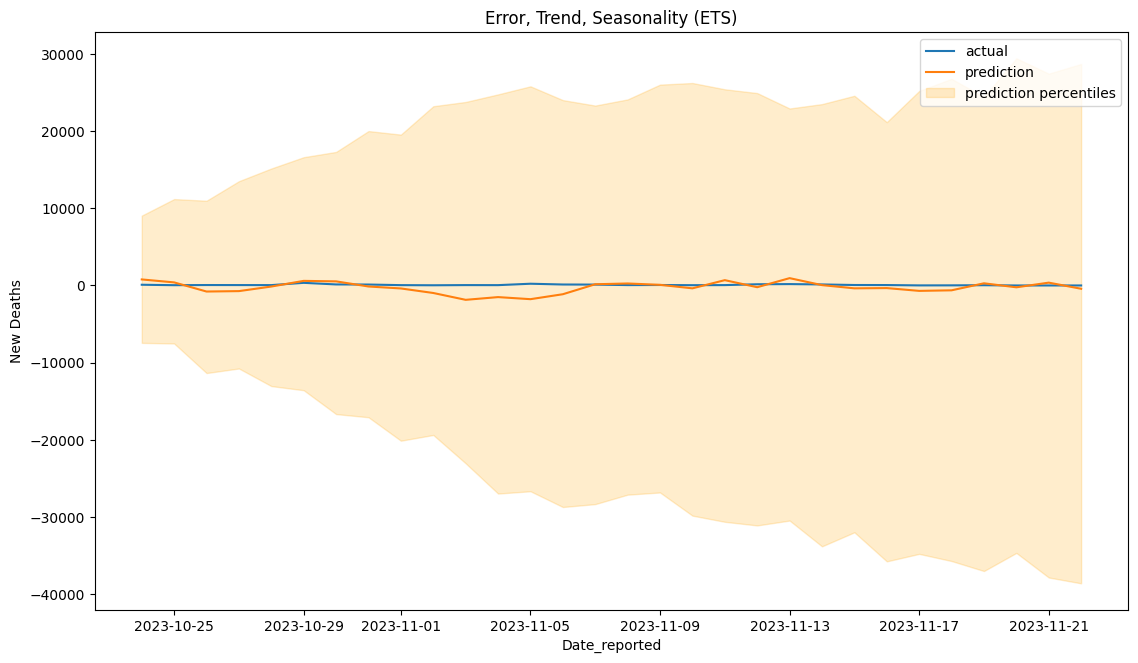

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.fill_between(
    p[date_column],
    p["prediction_5"],
    p["prediction_95"],
    alpha=0.2,
    color="orange",
    label="prediction percentiles",
)
ax.set_title("Error, Trend, Seasonality (ETS)")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [17]:
print_evaluation_metrics(p["prediction"], p[target_column])

Evaluation Metrics:
MSE: 605097.88
RMSE: 777.88
MAE: 598.16
MAPE: inf
SMAPE: 168.92


In [18]:
param_grid = {"global_trend_option": ["linear", "loglinear", "flat", "logistic"]}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

In [24]:
global_trend_options = ["linear", "loglinear", "flat", "logistic"]

dlt_scores = dict()


def dlt_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an ETS model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the DLT model configured with the given parameters.
    """
    return DLT(
        date_col=date_column,
        response_col=target_column,
        prediction_percentiles=[5, 95],
        regressor_col=["New_cases"],
        regressor_sign=["="],
        regression_penalty="auto_ridge",
        damped_factor=0.8,
        seed=2,
        verbose=False,
        **ets_best_params,
        **grid
    )


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(
            evaluate_grid, dlt_function, option, train, date_column, target_column
        ): option
        for option in combinations_as_dicts
    }
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        dlt_scores[json.dumps(option)] = score

chain 1 |          | 00:00 Status











































































































chain 1 |██▌       | 00:00 Status
























































































































chain 1 |█████     | 03:58 Iteration:   1 / 250 [  0%]  (Warmup)

















































































































chain 1 |███████▌  | 08:09 Iteration: 100 / 250 [ 40%]  (Warmup)








































































































chain 1 |██████████| 09:14 Iteration: 200 / 250 [ 80%]  (Warmup)




















































































































chain 1 |          | 10:20 Iteration: 226 / 250 [ 90%]  (Sampling)











chain 1 |██████████| 10:24 Sampling completed                     
chain 2 |██████████| 10:24 Sampl






























































































chain 1 |██████████| 10:33 Sampling completed                     
chain 2 |██████████| 10:33 Sampling completed                     
chain 3 |██████████| 10:33 Sampling completed                     
chain 4 |██████████| 10:33 Sampling completed                     

chain 1 |          | 00:00 Status
















chain 1 |██▌       | 00:00 Status





























chain 1 |██████████| 10:42 Sampling completed                     
chain 2 |██████████| 10:42 Sampling completed                     
chain 3 |██████████| 10:42 Sampling completed                     
chain 4 |██████████| 10:42 Sampling completed                     

























































































chain 1 |██████████| 11:31 Sampling completed                     
chain 2 |██████████| 11:31 Sampling completed                     
chain 3 |██████████| 11:31 Sampling completed                     
chain 4 |██████████| 11:31 Sampling completed                     






























































































































































chain 1 |███████▌  | 04:57 Iteration: 100 / 250 [ 40%]  (Warmup)











































chain 1 |██████████| 06:12 Iteration: 200 / 250 [ 80%]  (Warmup)









































chain 1 |          | 07:26 Iteration: 226 / 250 [ 90%]  (Sampling)







































































chain 1 |██████████| 09:07 Sampling completed                     
chain 2 |██████████| 09:07 Sampling completed                     
chain 3 |██████████| 09:07 Sampling completed                     
chain 4 |██████████| 09:07 Sampling completed                     































































































































chain 1 |██████████| 09:47 Sampling completed                     
chain 2 |██████████| 09:47 Sampling completed                     
chain 3 |██████████| 09:47 Sampling completed                     
chain 4 |██████████| 09:47 Sampling completed                     

chain 1 |          | 00:00 Status
















chain 1 |██▌       | 00:00 Status













































chain 1 |██████████| 10:27 Sampling completed                     
chain 2 |██████████| 10:27 Sampling completed                     
chain 3 |██████████| 10:27 Sampling completed                     
chain 4 |██████████| 10:27 Sampling completed                     













































































































chain 1 |██████████| 11:22 Sampling completed                     
chain 2 |██████████| 11:22 Sampling completed                     
chain 3 |██████████| 11:22 Sampling completed                     
chain 4 |██████████| 11:22 Sampling completed                     









































































































chain 1 |█████     | 03:46 Iteration:   1 / 250 [  0%]  (Warmup)


















































































































chain 1 |███████▌  | 08:12 Iteration: 100 / 250 [ 40%]  (Warmup)
























































chain 1 |██████████| 09:26 Iteration: 200 / 250 [ 80%]  (Warmup)













































chain 1 |██████████| 10:36 Sampling completed                     
chain 2 |██████████| 10:36 Sampling completed                     
chain 3 |██████████| 10:36 Sampling completed                     
chain 4 |██████████| 10:36 Sampling completed                     




































































































chain 1 |          | 10:40 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 10:43 Sampling completed                     
chain 2 |██████████| 10:43 Sampling completed                     
chain 3 |██████████| 10:43 Sampling completed                     
chain 4 |██████████| 10:43 Sampling completed                     

chain 1 |          | 00:00 Status
















chain 1 |██▌       | 00:00 Status



























































































chain 1 |██████████| 11:05 Sampling completed                     
chain 2 |██████████| 11:05 Sampling completed                     
chain 3 |██████████| 11:05 Sampling completed                     
chain 4 |██████████| 11:05 Sampling completed                     





























































































chain 1 |█████     | 02:38 Iteration:   1 / 250 [  0%]  (Warmup)

























chain 1 |██████████| 11:53 Sampling completed                     
chain 2 |██████████| 11:53 Sampling completed                     
chain 3 |██████████| 11:53 Sampling completed                     
chain 4 |██████████| 11:53 Sampling completed                     


























































































































































chain 1 |███████▌  | 07:09 Iteration: 100 / 250 [ 40%]  (Warmup)



















































chain 1 |██████████| 08:17 Iteration: 200 / 250 [ 80%]  (Warmup)








































chain 1 |██████████| 10:17 Sampling completed                     
chain 2 |██████████| 10:17 Sampling completed                     
chain 3 |██████████| 10:17 Sampling completed                     
chain 4 |██████████| 10:17 Sampling completed                     












































































chain 1 |          | 09:28 Iteration: 226 / 250 [ 90%]  (Sampling)














































































chain 1 |██████████| 10:58 Sampling completed                     
chain 2 |██████████| 10:58 Sampling completed                     
chain 3 |██████████| 10:58 Sampling completed                     
chain 4 |██████████| 10:58 Sampling completed                     

chain 1 |          | 00:00 Status
















chain 1 |██▌       | 00:00 Status
























































chain 1 |██████████| 11:08 Sampling completed                     
chain 2 |██████████| 11:08 Sampling completed                     
chain 3 |██████████| 11:08 Sampling completed                     
chain 4 |██████████| 11:08 Sampling completed                     

























































































































































chain 1 |█████     | 04:19 Iteration:   1 / 250 [  0%]  (Warmup)





































chain 1 |██████████| 12:22 Sampling completed                     
chain 2 |██████████| 12:22 Sampling completed                     
chain 3 |██████████| 12:22 Sampling completed                     
chain 4 |██████████| 12:22 Sampling completed                     























































































































































































chain 1 |███████▌  | 08:40 Iteration: 100 / 250 [ 40%]  (Warmup)





































chain 1 |██████████| 10:43 Sampling completed                     
chain 2 |██████████| 10:43 Sampling completed                     
chain 3 |██████████| 10:43 Sampling completed                     
chain 4 |██████████| 10:43 Sampling completed                     





















chain 1 |██████████| 09:40 Iteration: 200 / 250 [ 80%]  (Warmup)























































chain 1 |          | 10:34 Iteration: 226 / 250 [ 90%]  (Sampling)









chain 1 |██████████| 10:47 Sampling completed                     
chain 2 |██████████| 10:47 Sampling completed                     
chain 3 |██████████| 10:47 Sampling completed                     
chain 4 |██████████| 10:47 Sampling completed                     



















chain 1 |██████████| 10:17 Sampling completed                     
chain 2 |██████████| 10:17 Sampling completed                     
chain 3 |██████████| 10:17 Sampling completed                     
chain 4 |██████████| 10:17 Sampling completed                     





















































































chain 1 |██████████| 09:25 Sampling completed                     
chain 2 |██████████| 09:25 Sampling completed                     
chain 3 |██████████| 09:25 Sampling completed                     
chain 4 |██████████| 09:25 Sampling completed                     

In [27]:
dlt_best_params = json.loads(min(dlt_scores, key=dlt_scores.get))
dlt_scores

{'{"global_trend_option": "flat"}': 3536.0197947497836,
 '{"global_trend_option": "linear"}': 3519.0273359366047,
 '{"global_trend_option": "loglinear"}': 3507.720205611724,
 '{"global_trend_option": "logistic"}': 3517.795209112036}

In [28]:
dlt = DLT(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    regressor_col=["New_cases"],
    regressor_sign=["="],
    regression_penalty="auto_ridge",
    damped_factor=0.8,
    seed=2,
    verbose=False,
    **ets_best_params,
    **dlt_best_params
)

dlt.fit(train)
p = dlt.predict(df=valid[[date_column, "New_cases"]])
p = p.merge(valid, on=date_column, how="left")

chain 1 |          | 00:00 Status







chain 1 |█████     | 03:27 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 07:24 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 08:26 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 09:36 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 09:42 Sampling completed                     
chain 2 |██████████| 09:42 Sampling completed                     
chain 3 |██████████| 09:42 Sampling completed                     
chain 4 |██████████| 09:42 Sampling completed                     

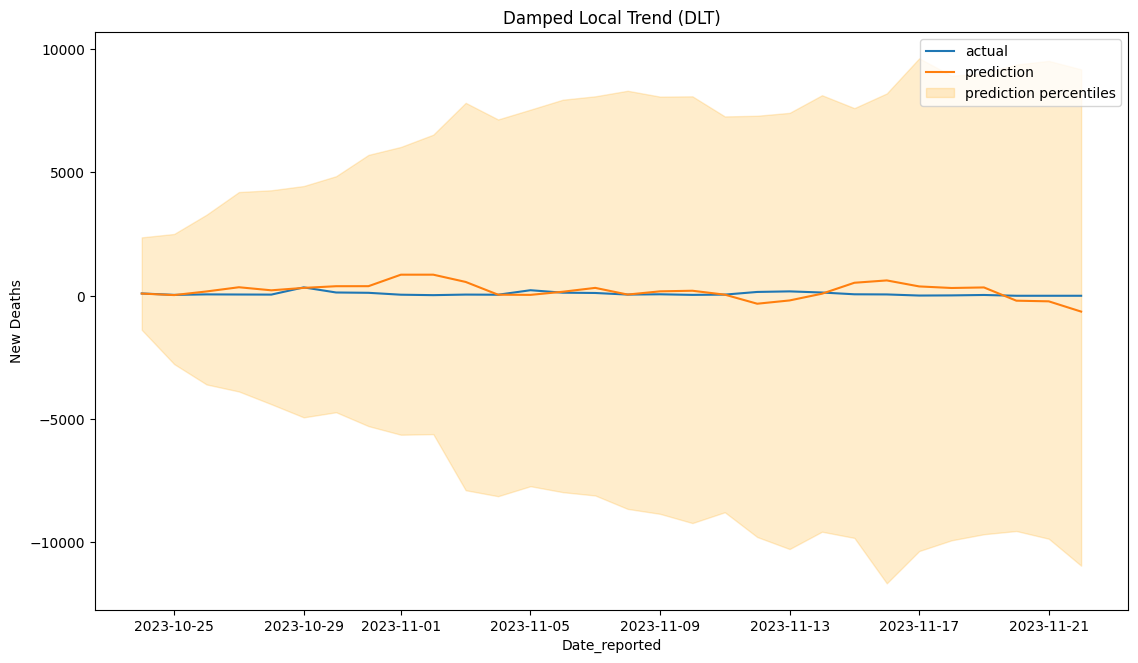

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.fill_between(
    p[date_column],
    p["prediction_5"],
    p["prediction_95"],
    alpha=0.2,
    color="orange",
    label="prediction percentiles",
)
ax.set_title("Damped Local Trend (DLT)")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [30]:
print_evaluation_metrics(p["prediction"], p[target_column])

Evaluation Metrics:
MSE: 124473.28
RMSE: 352.81
MAE: 266.64
MAPE: inf
SMAPE: 119.58


In [35]:
ktr = KTR(
    date_col=date_column,
    response_col=target_column,
    seasonality=[90, 180, 360],
    prediction_percentiles=[5, 95],
    regressor_col=["New_cases"],
    seed=2,
    verbose=False,
)

ktr.fit(df=train)

p = ktr.predict(df=valid[[date_column, "New_cases"]])
p = p.merge(valid, on=date_column, how="left")

2023-11-26 15:14:48 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


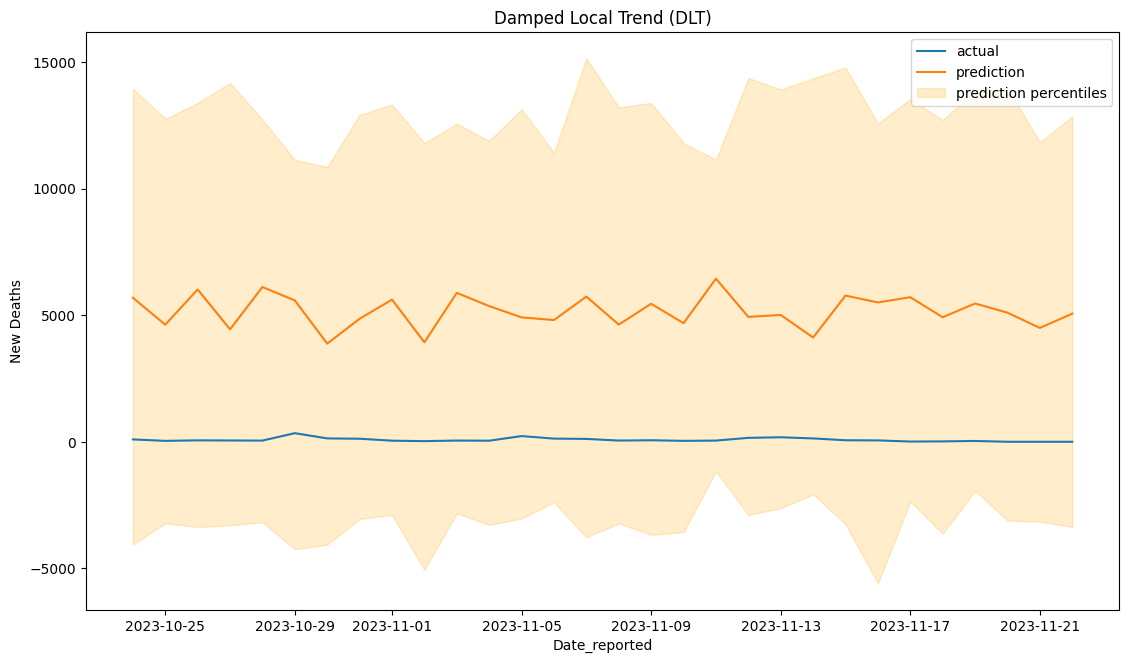

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.fill_between(
    p[date_column],
    p["prediction_5"],
    p["prediction_95"],
    alpha=0.2,
    color="orange",
    label="prediction percentiles",
)
ax.set_title("Damped Local Trend (DLT)")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [37]:
print_evaluation_metrics(p["prediction"], p[target_column])

Evaluation Metrics:
MSE: 26242768.32
RMSE: 5122.77
MAE: 5081.76
MAPE: inf
SMAPE: 194.04
